# Notebook to make the graphs

## Reading the CSV files with the data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Direct / No self-correction

metrics_direct_no_corr = pd.read_csv("experiments/RAG_Python/metrics_gpt-4o_2025-07-07T15-54-24.csv")

# Step-by-step / No self-correction

metrics_step_no_corr = pd.read_csv("experiments/RAG_Python/metrics_gpt-4o_2025-07-07T13-50-18.csv")
    
# Direct / Self-correction

metrics_direct_corr = pd.read_csv("experiments/RAG_Python/metrics_gpt-4o_2025-07-07T18-52-36.csv")

# Step-by-step / Self-correction

metrics_step_corr = pd.read_csv("experiments/RAG_Python/metrics_gpt-4o_2025-07-07T11-13-30.csv")

In [44]:
# Adding gold_difficulty column for the graphs

df_test = pd.read_csv("datasets/txt2sql_alerce_test_v3_1.csv")
metrics_step_corr["gold_difficulty"] = ""
metrics_direct_corr["gold_difficulty"] = ""
metrics_step_no_corr["gold_difficulty"] = ""
metrics_direct_no_corr["gold_difficulty"] = ""

for req_id in df_test["req_id"].unique():
    mask = (metrics_step_corr["query_id"] == req_id) & (metrics_step_corr["query_run"] != 0)
    metrics_step_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_direct_corr["query_id"] == req_id) & (metrics_direct_corr["query_run"] != 0)
    metrics_direct_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_step_no_corr["query_id"] == req_id) & (metrics_step_no_corr["query_run"] != 0)
    metrics_step_no_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_direct_no_corr["query_id"] == req_id) & (metrics_direct_no_corr["query_run"] != 0)
    metrics_direct_no_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    #print(df_test.loc[df_test.req_id == req_id, "difficulty"].item())

## Obtaining execution metrics

In [45]:
# Function to obtain the metrics for each case
def metrics(df):
    """Function to obtain the Execution metrics for each dataframe

    Args:
        df (pandas. DataFrame): DataFrame with the unitary metrics

    Returns:
        dict: Dictionary with all the Execution metrics obtained
    """
    # Obtain ER and EP for rows and columns
    # ER
    ER_row = df["r_row"].mean().round(2)
    ER_col = df["r_col"].mean().round(2)
    # EP
    EP_row = df["p_row"].mean().round(2)
    EP_col = df["p_col"].mean().round(2)
    
    # Obtain the EF-Score
    EF_row = ((2 * ER_row * EP_row) / (EP_row + ER_row)).round(2)
    EF_col = ((2 * ER_col * EP_col) / (EP_col + ER_col)).round(2)
    
    # Build result dictionary
    result_dict = {
        "Row metrics": {
            "ER": ER_row,
            "EP": EP_row,
            "EF-Score": EF_row
        },
        "Column metrics": {
            "ER": ER_col,
            "EP": EP_col,
            "EF-Score": EF_col
        }
    }
    
    return result_dict

In [46]:
# Obtaining all the metrics for this config
print("-"*100)
print("Direct / No self - correction")
print(metrics(metrics_direct_no_corr))
print("-"*100)

print("Step-by-step / No self-correction")
print(metrics(metrics_step_no_corr))
print("-"*100)

print("Direct / Self-correction")
print(metrics(metrics_direct_corr))
print("-"*100)

print("Step-by-step / Self-correction")
print(metrics(metrics_step_corr))
print("-"*100)

----------------------------------------------------------------------------------------------------
Direct / No self - correction
{'Row metrics': {'ER': 0.18, 'EP': 0.18, 'EF-Score': 0.18}, 'Column metrics': {'ER': 0.19, 'EP': 0.19, 'EF-Score': 0.19}}
----------------------------------------------------------------------------------------------------
Step-by-step / No self-correction
{'Row metrics': {'ER': 0.17, 'EP': 0.17, 'EF-Score': 0.17}, 'Column metrics': {'ER': 0.19, 'EP': 0.19, 'EF-Score': 0.19}}
----------------------------------------------------------------------------------------------------
Direct / Self-correction
{'Row metrics': {'ER': 0.31, 'EP': 0.33, 'EF-Score': 0.32}, 'Column metrics': {'ER': 0.35, 'EP': 0.36, 'EF-Score': 0.35}}
----------------------------------------------------------------------------------------------------
Step-by-step / Self-correction
{'Row metrics': {'ER': 0.32, 'EP': 0.33, 'EF-Score': 0.32}, 'Column metrics': {'ER': 0.35, 'EP': 0.36, 'EF-Sco

## Making the graphs

### No self-correction

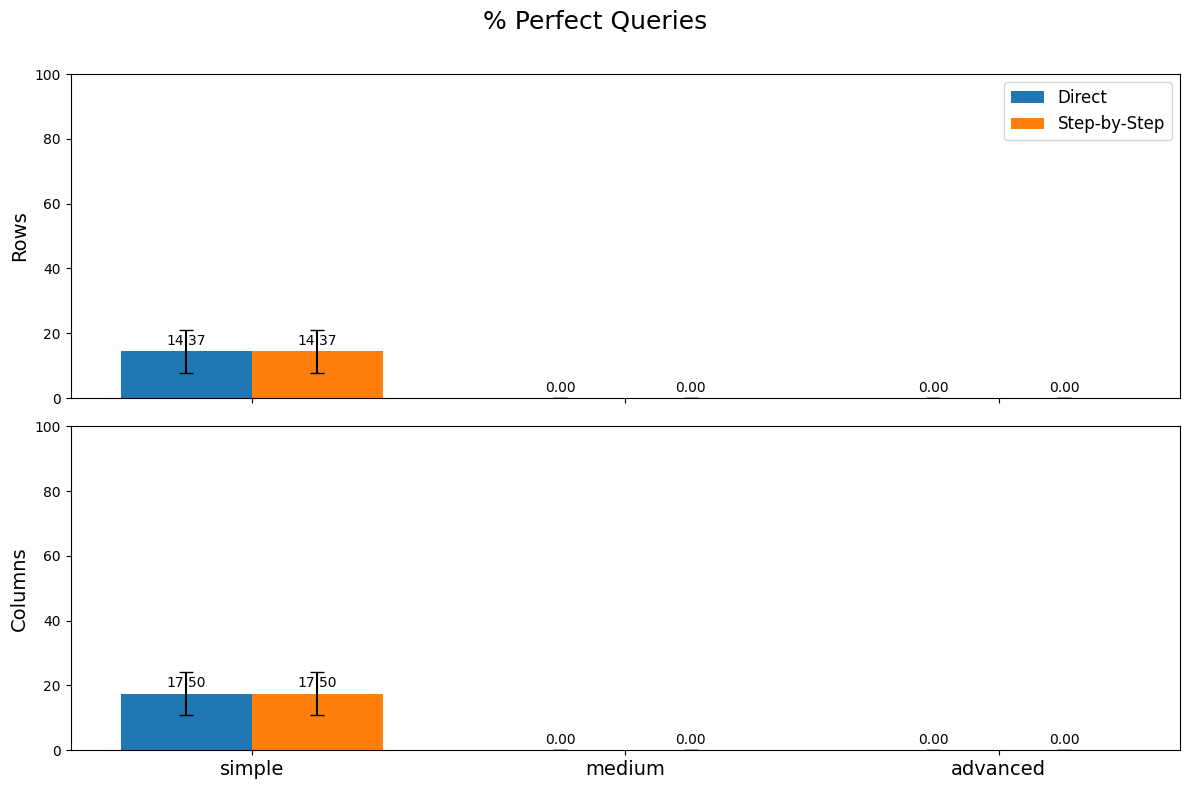

In [47]:
# Add prompt type before combining
metrics_direct_no_corr['prompt_type'] = 'Direct'
metrics_step_no_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_no_corr = metrics_direct_no_corr[metrics_direct_no_corr["query_run"] != 0]
metrics_step_no_corr = metrics_step_no_corr[metrics_step_no_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_no_corr, metrics_step_no_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:  # cambiar nombre label a difficulty
    for prompt in ['Direct', 'Step-by-Step']:
        # print(label, prompt)
        subset = df_all[(df_all['gold_difficulty'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_mean = subset['N_perfect_row'].mean()
        # row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        row_std = subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).mean()
        # display(subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).value_counts())
        
        # ---- Columns ----
        col_mean = subset['N_perfect_col'].mean()
        # col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()
        col_std = subset.groupby('query_id')['N_perfect_col'].apply(pd.Series.std).mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_mean * 100,
            'std_row': row_std * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_mean * 100,
            'std_col': col_std * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=18)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows", fontsize=14)
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns", fontsize=14)
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order, fontsize=14)

# Legend
axs[0].legend(loc="upper right", fontsize=12)

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


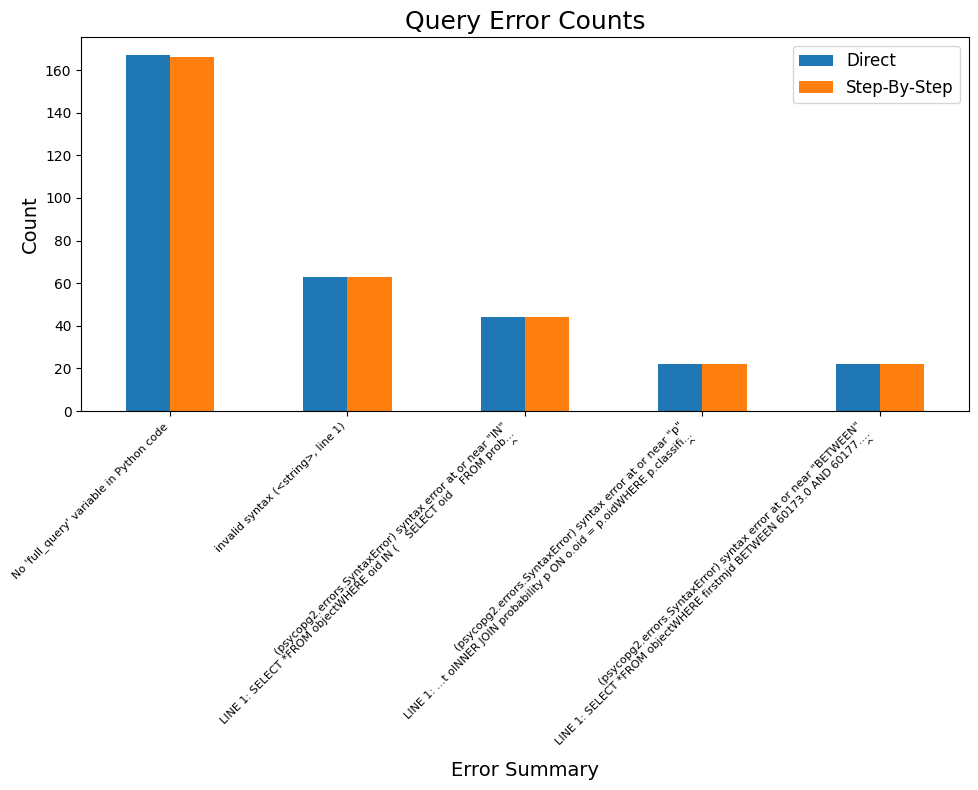

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Preprocess the error labels
processed_dir = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Direct']["query_error"]
]

processed_step = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Step-by-Step']["query_error"]
]

# Count and filter
counts_dir = pd.Series(processed_dir).value_counts()
counts_step = pd.Series(processed_step).value_counts()

# Combine both counts into a DataFrame
df_counts = pd.DataFrame({
    'Direct': counts_dir,
    'Step-By-Step': counts_step
}).fillna(0)

# Filter only the rows with at least one count > 10
df_counts = df_counts[df_counts.max(axis=1) > 10]

# Plot grouped bar chart
ax = df_counts.plot(kind='bar', figsize=(10, 8))

plt.title('Query Error Counts', fontsize=18)
plt.xlabel('Error Summary', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(title='', fontsize=12)
plt.tight_layout()
plt.show()

### With self-correction

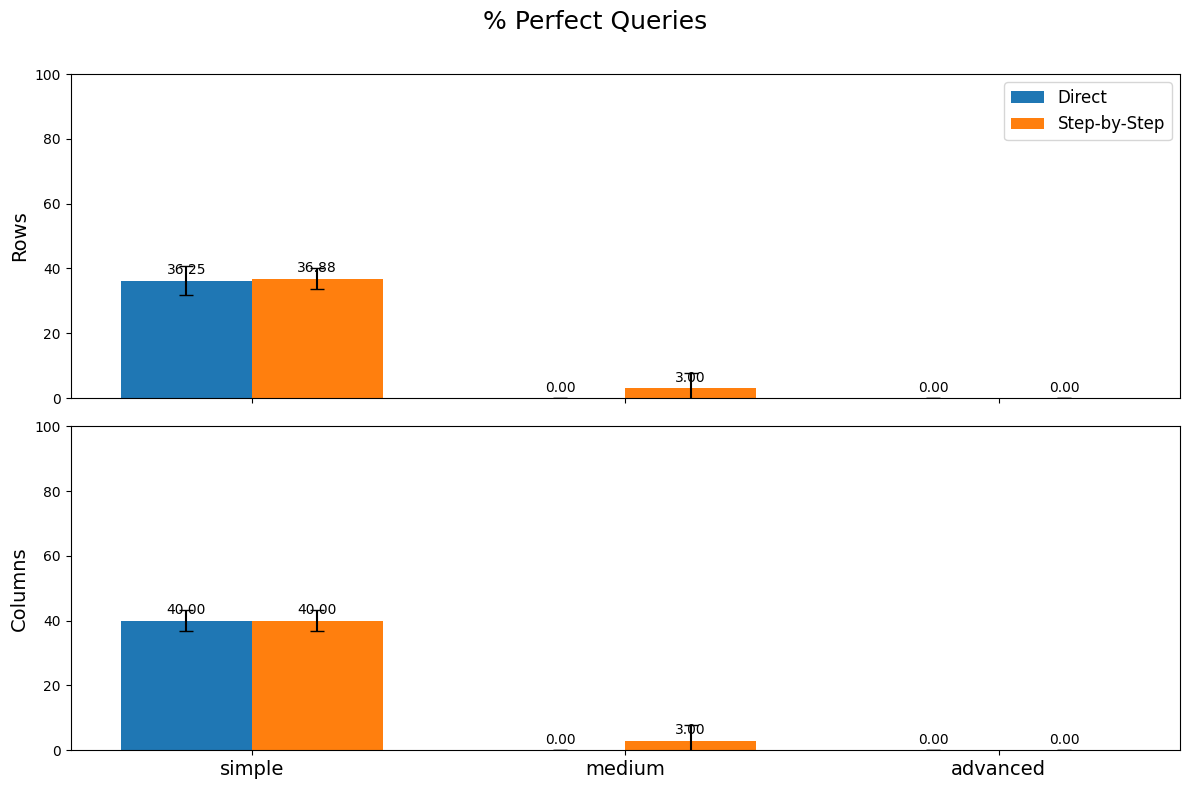

In [49]:
# Add prompt type before combining
metrics_direct_corr['prompt_type'] = 'Direct'
metrics_step_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_corr = metrics_direct_corr[metrics_direct_corr["query_run"] != 0]
metrics_step_corr = metrics_step_corr[metrics_step_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_corr, metrics_step_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:
    for prompt in ['Direct', 'Step-by-Step']:
        # print(label, prompt)
        subset = df_all[(df_all['gold_difficulty'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_mean = subset['N_perfect_row'].mean()
        # row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        row_std = subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).mean()
        # display(subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).value_counts())
        
        # ---- Columns ----
        col_mean = subset['N_perfect_col'].mean()
        # col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()
        col_std = subset.groupby('query_id')['N_perfect_col'].apply(pd.Series.std).mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_mean * 100,
            'std_row': row_std * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_mean * 100,
            'std_col': col_std * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=18)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows", fontsize=14)
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns", fontsize=14)
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order, fontsize=14)

# Legend
axs[0].legend(loc="upper right", fontsize=12)

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

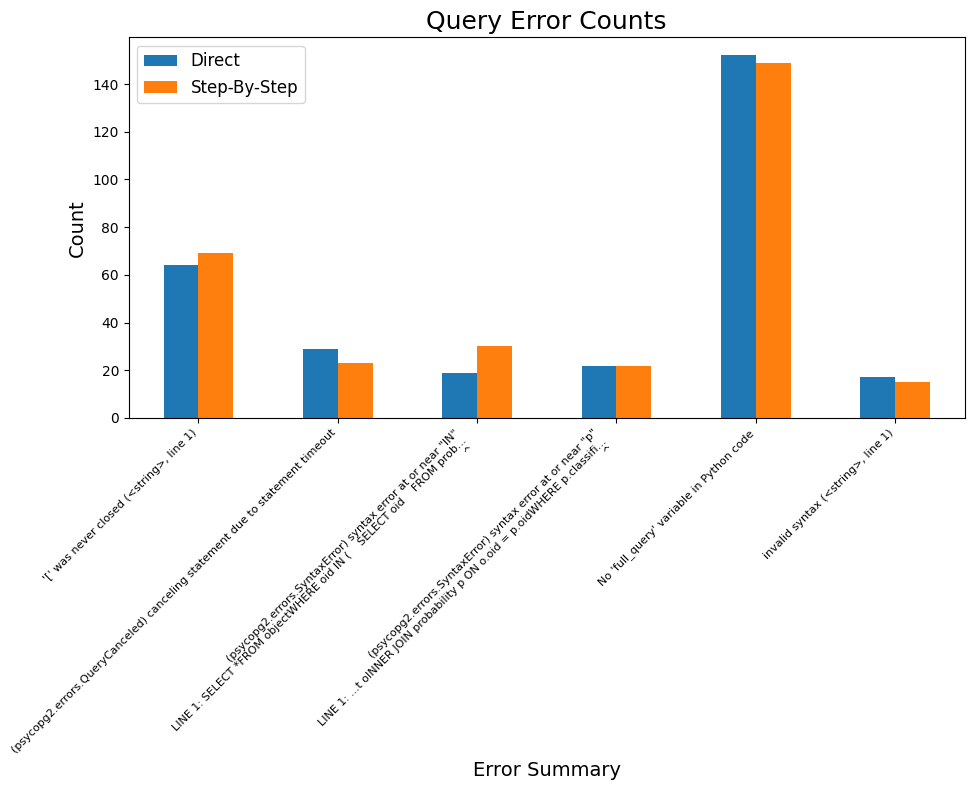

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Preprocess the error labels
processed_dir = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Direct']["query_error"]
]

processed_step = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Step-by-Step']["query_error"]
]

# Count and filter
counts_dir = pd.Series(processed_dir).value_counts()
counts_step = pd.Series(processed_step).value_counts()

# Combine both counts into a DataFrame
df_counts = pd.DataFrame({
    'Direct': counts_dir,
    'Step-By-Step': counts_step
}).fillna(0)

# Filter only the rows with at least one count > 10
df_counts = df_counts[df_counts.max(axis=1) > 10]

# Plot grouped bar chart
ax = df_counts.plot(kind='bar', figsize=(10, 8))

plt.title('Query Error Counts', fontsize=18)
plt.xlabel('Error Summary', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(title='', fontsize=12)
plt.tight_layout()
plt.show()